In [2]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# If you need to determine the percent voxel change between two images follow these steps first. 

## If you already have a "percent.csv" file, skip to next section

In [34]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"
affinefile = os.path.join(src, "output_dirs/Chon_PRA_affine_1/result.tif")
transformixedfile = os.path.join(src, "output_dirs/Chon_1_PRA/result.tif")
annotationsfilename = os.path.join(src,"labels/chon_label_ids.csv")

In [35]:
affine = tif.imread(affinefile)
print("read affine tiff")
transformixed = tif.imread(transformixedfile)
print("read transformixed tiff")

read affine tiff
read transformixed tiff


In [36]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1],header=0,names=['id','abbr'])
print("read annotations")

read annotations


In [37]:
df=anns.dropna()
df

,id,abbr
0,1,VTM
1,2,S1ULp-6b
2,3,sf
3,4,IC
4,6,ic
...,...,...
4284,58500,8Cb-mo
4285,59100,9Cb-gr
4286,58900,9Cb-mo
4287,59500,10Cb-gr


In [38]:
df.insert(2,'affine_vox',0)
df.insert(3,'transformixed_vox',0)


In [39]:
for i in df['id']:
    df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
    df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


<ipython-input-39-ec990ef16611>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
<ipython-input-39-ec990ef16611>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


In [40]:
df

,id,abbr,affine_vox,transformixed_vox
0,1,VTM,3966,4012
1,2,S1ULp-6b,58899,55267
2,3,sf,0,0
3,4,IC,0,0
4,6,ic,456051,427816
...,...,...,...,...
4284,58500,8Cb-mo,0,0
4285,59100,9Cb-gr,0,0
4286,58900,9Cb-mo,0,0
4287,59500,10Cb-gr,0,0


In [41]:
df['change'] = df['affine_vox']-df['transformixed_vox']

In [42]:
dfwithzero=df

In [43]:
df = df[df.transformixed_vox > 0]
df

,id,abbr,affine_vox,transformixed_vox,change
0,1,VTM,3966,4012,-46
1,2,S1ULp-6b,58899,55267,3632
4,6,ic,456051,427816,28235
5,7,Pr5,51468,53286,-1818
7,9,S1Tr-6a,36807,40706,-3899
...,...,...,...,...,...
3767,2010,FrC3,28410,28258,152
4068,810,FrA-5,25593,26181,-588
4079,2040,FrC3-5,42111,41675,436
4080,2050,FrC3-6a,54567,45119,9448


In [44]:
dfpercent = (df['change']/df['transformixed_vox'])*100
dfpercent[np.isinf(dfpercent)]=0
df['percent'] = dfpercent
dfpercent.replace(0,np.nan)

<ipython-input-44-fce1c83d1c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent'] = dfpercent


0       -1.146560
1        6.571734
4        6.599800
5       -3.411778
7       -9.578441
          ...    
3767     0.537901
4068    -2.245904
4079     1.046191
4080    20.940180
4094    23.379375
Length: 1589, dtype: float64

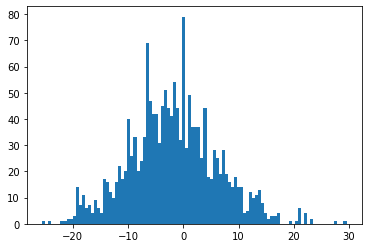

In [45]:
plt.hist(df.percent,bins=100)
plt.show()

In [46]:
mp = np.nanmedian(df.percent)
sp = np.nanstd(df.percent)

In [47]:
highmp = mp+sp
highmp

6.041034408049766

In [48]:
lowmp = mp-sp
lowmp

-9.831121871606618

In [50]:
percentcsv="/home/emilyjanedennis/Desktop/percent.csv"
df.to_csv(percentcsv)

In [51]:
df=pd.read_csv(percentcsv)

In [52]:
df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,1,VTM,3966,4012,-46,-1.146560
1,1,2,S1ULp-6b,58899,55267,3632,6.571734
2,4,6,ic,456051,427816,28235,6.599800
3,5,7,Pr5,51468,53286,-1818,-3.411778
4,7,9,S1Tr-6a,36807,40706,-3899,-9.578441
...,...,...,...,...,...,...,...
1584,3767,2010,FrC3,28410,28258,152,0.537901
1585,4068,810,FrA-5,25593,26181,-588,-2.245904
1586,4079,2040,FrC3-5,42111,41675,436,1.046191
1587,4080,2050,FrC3-6a,54567,45119,9448,20.940180


In [53]:
too = df.id
zeroed = dfwithzero.id

In [54]:
transformixed_relative = transformixed

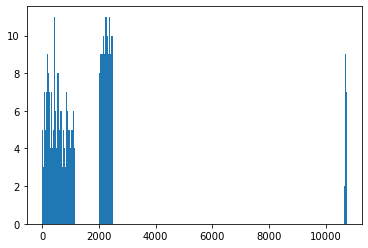

In [55]:
# add list of unique values not in twoxh/twoxl but in transformixed
x = np.unique(affine)
plt.hist(x,bins=1000)
plt.show()

In [56]:
test = np.setdiff1d(x,too)
test[1:20]

array([], dtype=int16)

In [57]:
for i in test:
    transformixed_relative[transformixed_relative==i]=0

In [58]:
for i in too:
    transformixed_relative[transformixed_relative==i]=df.loc[df['id']==i,'percent'].iloc[0]

In [59]:
tif.imsave("/home/emilyjanedennis/Desktop/transformixed_relative_tiff.tiff",transformixed_relative)

# If you already have a percent file

In [60]:
df=pd.read_csv(percentcsv)

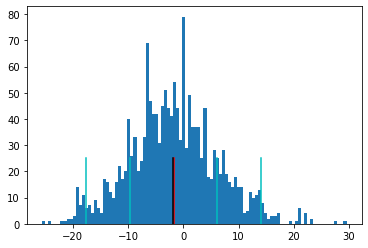

In [61]:
plt.hist(df.percent[df.affine_vox>5],bins=100)

dfmean = np.nanmean(df.percent[df.affine_vox>5])
dfmedian = np.nanmedian(df.percent[df.affine_vox>5])
dfstd = np.std(df.percent[df.affine_vox>5])
mp = dfmean + dfstd
mm = dfmean - dfstd

mp2 = dfmean + 2*dfstd
mp3 = dfmean + 3*dfstd
mm2 = dfmean - 2*dfstd
mm3 = dfmean - 3*dfstd


plt.plot([dfmean, dfmean],[0,25],'r')
plt.plot([dfmedian, dfmedian],[0,25],'k')
plt.plot([mp,mp],[0,25],'c')
plt.plot([mm,mm],[0,25],'c')
plt.plot([mp2,mp2],[0,25],'c')
plt.plot([mm2,mm2],[0,25],'c')
plt.show()

In [62]:
# want to make summary -- ideally show a ranked 3, 2, 1std>mean 
# in diff colors, and then the 
# values either written or in bar form on the right

df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,1,VTM,3966,4012,-46,-1.146560
1,1,2,S1ULp-6b,58899,55267,3632,6.571734
2,4,6,ic,456051,427816,28235,6.599800
3,5,7,Pr5,51468,53286,-1818,-3.411778
4,7,9,S1Tr-6a,36807,40706,-3899,-9.578441
...,...,...,...,...,...,...,...
1584,3767,2010,FrC3,28410,28258,152,0.537901
1585,4068,810,FrA-5,25593,26181,-588,-2.245904
1586,4079,2040,FrC3-5,42111,41675,436,1.046191
1587,4080,2050,FrC3-6a,54567,45119,9448,20.940180


In [63]:
df2p = df[df.percent>mp2]
df2p = df2p.sort_values('percent',ascending=False)
df2m = df[df.percent < mm2]
df2m = df2m.sort_values('percent',ascending=False)

In [74]:
df2m=df2m.drop_duplicates('id')

In [75]:
df2p=df2p.drop_duplicates('id')

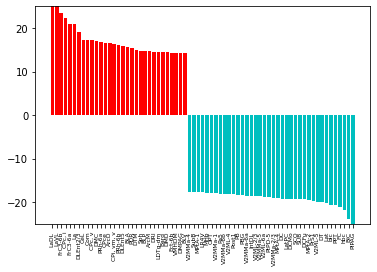

In [77]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=6)
plt.ylim([-25,25])
plt.show()